In [1]:
# install the Keras-tuner library
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2

from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# set random seeds to get reproducible results
import os
seed = 100
os.environ['PYTHONHASHSEED']=str(seed)
keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)


In [3]:
# load the data set GitHub URL .
df = pd.read_csv('https://raw.githubusercontent.com/kechyy/DNN_Diabetes_predictions/refs/heads/master/data/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/kechyy/DNN_Diabetes_predictions/refs/heads/master/data/test.csv')


# Rename columns for better readability
df.rename(columns={
    'A1': 'Pregnancies',
    'A2': 'Glucose',
    'A3': 'BloodPressure',
    'A4': 'SkinThickness',
    'A5': 'Insulin',
    'A6': 'BMI',
    'A7': 'DiabetesPedigreeFunction',
    'A8': 'Age',
    'class': 'Outcome'
}, inplace=True)

# Drop Unnecessary Columns
df.drop(columns=['id'], inplace=True, errors='ignore')

# Display the first few rows and basic information
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
 # summarise the details
print(f'Number of entries: {df.shape}')


Number of entries: (668, 9)


In [5]:
print("\nBasic dataset information:")
df.info()



Basic dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               668 non-null    int64  
 1   Glucose                   668 non-null    int64  
 2   BloodPressure             668 non-null    int64  
 3   SkinThickness             668 non-null    int64  
 4   Insulin                   668 non-null    int64  
 5   BMI                       668 non-null    float64
 6   DiabetesPedigreeFunction  668 non-null    float64
 7   Age                       668 non-null    int64  
 8   Outcome                   668 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 47.1 KB


In [ ]:

print("\nStatistical summary:")
df.describe()


Statistical summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,3.812874,120.405689,68.748503,20.567365,79.654192,31.860180,0.477329,33.091317,0.345808
std,3.365672,32.291473,19.526392,16.020600,115.827750,7.827111,0.341398,11.711386,0.475988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.238750,24.000000,0.000000
50%,3.000000,116.000000,72.000000,23.000000,36.500000,32.000000,0.377000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,126.000000,36.500000,0.641250,40.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Data Cleaning and Preprocessing
print("\nData Cleaning and Preprocessing")

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Data Cleaning and Preprocessing

Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [16]:
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
def check_for_zero():
  # Check for zero values in columns where zeros are physiologically impossible
  for column in zero_columns:
      if column in df.columns:
          zero_count = (df[column] == 0).sum()
          if zero_count > 0:
              print(f"Number of zeros in {column}: {zero_count}")
          else:
              print(f"No zeros found in {column}")



No zeros found in Glucose
No zeros found in BloodPressure
No zeros found in SkinThickness
No zeros found in Insulin
No zeros found in BMI


In [10]:
# Replace zeros with NaN for physiologically impossible zero values
for column in zero_columns:
    if column in df.columns:
        df[column] = df[column].replace(0, np.nan)
print("\nAfter cleaning, missing values in each column:")
print(df.isnull().sum())


After cleaning, missing values in each column:
Pregnancies                   0
Glucose                       5
BloodPressure                32
SkinThickness               196
Insulin                     322
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [11]:
for column in df.columns:
    if df[column].isnull().sum() > 0:
        column_median = df[column].median()
        df[column] = df[column].fillna(column_median)

print("\nAfter cleaning, missing values in each column:")
print(df.isnull().sum())


After cleaning, missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


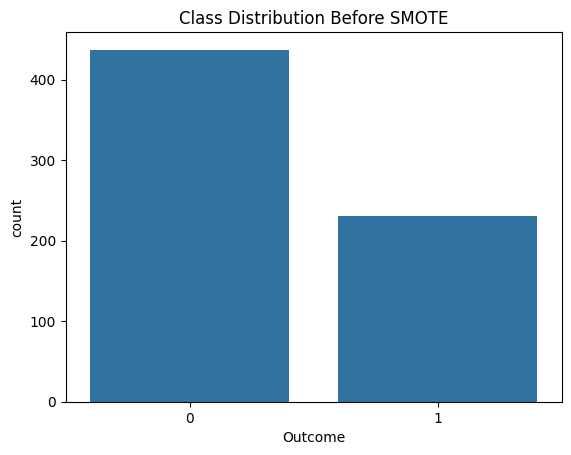

In [12]:
# Summarise class details
sns.countplot(x=df["Outcome"])
plt.title("Class Distribution Before SMOTE")
plt.show()

In [13]:
#Check for Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


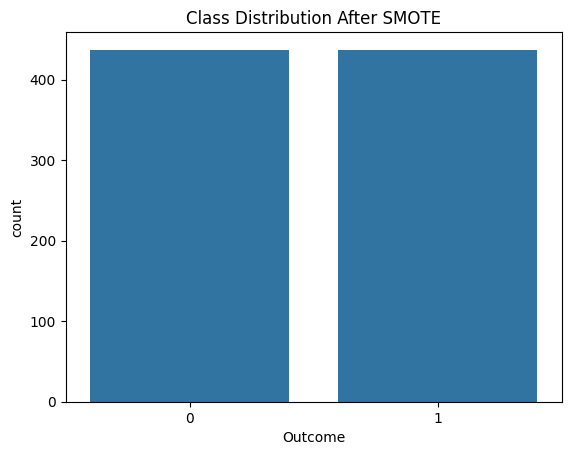

No zeros found in Glucose
No zeros found in BloodPressure
No zeros found in SkinThickness
No zeros found in Insulin
No zeros found in BMI


In [17]:
# Step 7: Separate Features and Target Variable
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Step 8: Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=100)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create Balanced DataFrame
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'DiabetesPedigreeFunction', 'BMI', 'Age']
df_balanced = pd.DataFrame(X_resampled, columns=columns)
df_balanced["Outcome"] = y_resampled

# Summarize Class Distribution After SMOTE
sns.countplot(x=df_balanced["Outcome"])
plt.title("Class Distribution After SMOTE")
plt.show()

# Step 9: Split into Training and Test Sets (AFTER SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=100)

# Step 10: Scale the Data (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

check_for_zero()

In [148]:
X_resampled.shape

(874, 8)

In [31]:
# clear session
tf.keras.backend.clear_session()

# set random seed
tf.keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)

In [27]:
model = Sequential([
    # Hidden Layer
    Dense(32, activation='relu', input_shape=(X_train.shape[1],),
           kernel_regularizer=l2(0.009)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.009)),
    Dense(1, activation='sigmoid')  # Binary Classification
])

# Compile the model with the best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,465 (9.63 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train Model with Callbacks
history = model.fit(
    X_train_scaled, y_train,
    epochs=60,
    validation_data=(X_test_scaled, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  # Extended patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)  # Gradual LR reduction
    ]
)

Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5436 - loss: 1.1982 - val_accuracy: 0.5257 - val_loss: 1.1531 - learning_rate: 5.0000e-04
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5739 - loss: 1.1143 - val_accuracy: 0.6800 - val_loss: 1.0785 - learning_rate: 5.0000e-04
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6775 - loss: 1.0533 - val_accuracy: 0.7314 - val_loss: 1.0208 - learning_rate: 5.0000e-04
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7126 - loss: 1.0039 - val_accuracy: 0.7429 - val_loss: 0.9722 - learning_rate: 5.0000e-04
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7155 - loss: 0.9616 - val_accuracy: 0.7371 - val_loss: 0.9297 - learning_rate: 5.0000e-04
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7093 - loss: 0.9244 - val_accuracy: 0.7543 - val_loss: 0.8915 - learning_rate: 5.0000e-04
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7124 - loss

In [32]:
# Step 15: Evaluate the Model
loss, accuracy = model.evaluate(X_train_scaled, y_train)
print(f"\nTraining Accuracy: {accuracy * 100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8278 - loss: 0.4832

Training Accuracy: 81.69%


In [33]:
# Step 15: Evaluate the Model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7724 - loss: 0.5889 

Test Accuracy: 80.00%


In [34]:
# Convert probabilities to binary (0 or 1) using a threshold of 0.5
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

pd.DataFrame(y_pred).value_counts()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,count
0,
1,90
0,85


In [35]:
from sklearn.metrics import accuracy_score, classification_report

# Get actual test labels
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.85      0.77      0.80        94
           1       0.76      0.84      0.80        81

    accuracy                           0.80       175
   macro avg       0.80      0.80      0.80       175
weighted avg       0.80      0.80      0.80       175



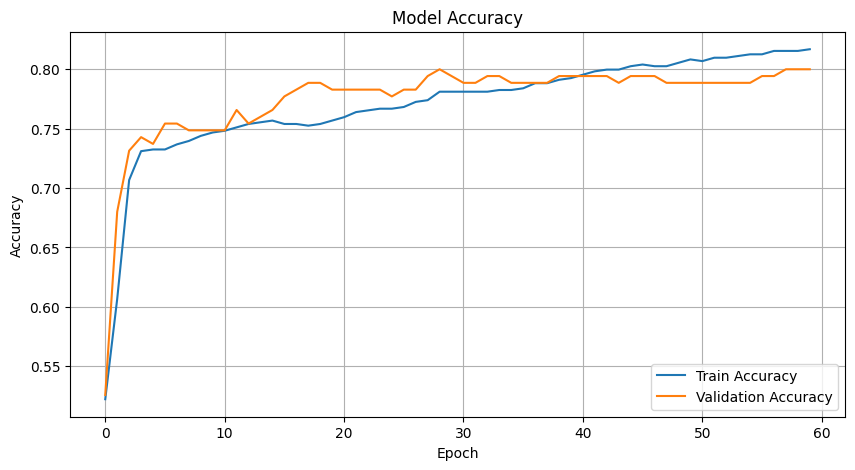

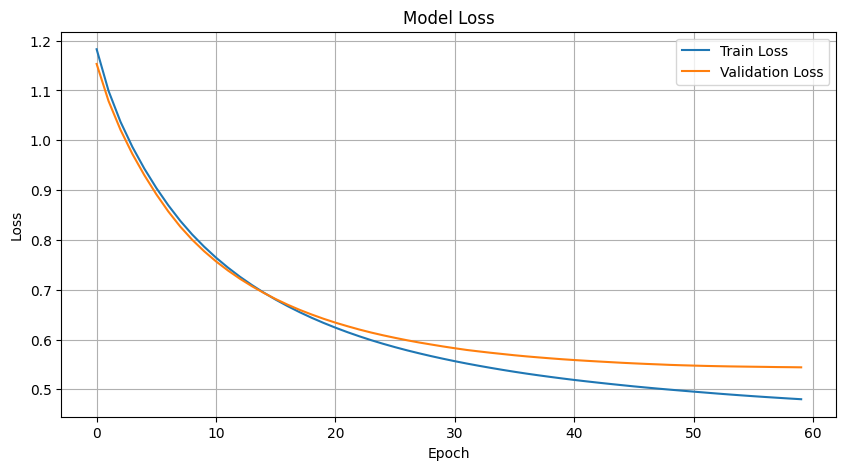

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()